In [471]:
from tranction_reduction import TranctionReduction
import pandas as pd
import numpy as np
import numpy_indexed as npi
from itertools import combinations, product
from functools import reduce
from collections.abc import Iterable
import math
import timeit
# use for vertify
import matplotlib.pyplot as plt
import apriori


In [472]:
real_dataset_path = "/home/sokhorn/sokhorn/dataSet/data/Online Retail.csv"
# testing_dataset_path = '/home/sokhorn/sokhorn/dataSet/data/sample_data_set.csv'
tranction_reduction_itemsets = '/home/sokhorn/sokhorn/dataSet/data/sample_tranc_red.csv'
sample_dataset = pd.read_csv(
    tranction_reduction_itemsets, sep=',', usecols=[
        'InvoiceNo',
        'StockCode',
        'Quantity'
    ])
sample_dataset
item_sets = (
    sample_dataset.groupby(['InvoiceNo', 'StockCode', ])['Quantity']
    .sum().unstack().reset_index().fillna(0)
    .set_index("InvoiceNo")
)
item_sets = item_sets.iloc[:, :150]
item_sets = item_sets.head(958)
item_sets = item_sets.applymap(lambda x: 1 if x > 0 else 0)
item_sets.reindex(sorted(item_sets.columns), axis=1)
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [473]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [474]:
tranc_reduction = TranctionReduction(item_sets)


In [475]:
min_supports = [5, 10, 15, 20, 25]


In [476]:
result = []


In [477]:
df_rc, rc = tranc_reduction.df_rc(item_sets)
df_rc


,I1,I2,I3,I4,I5
0,1,1,0,0,1
1,0,1,0,1,0
2,0,1,1,0,0
3,1,1,0,1,0
4,1,0,1,0,0
5,1,1,1,0,1
6,1,1,1,0,0


### Computing theminimum0-support for mining frequent patterns


In [478]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [479]:
tranc_reduction_apri = TranctionReduction(item_sets)
tranc_reduction_apri.df_rc(item_sets)


(   I1  I2  I3  I4  I5
 0   1   1   0   0   1
 1   0   1   0   1   0
 2   0   1   1   0   0
 3   1   1   0   1   0
 4   1   0   1   0   0
 5   1   1   1   0   1
 6   1   1   1   0   0,
 0    1
 1    1
 2    2
 3    1
 4    2
 5    1
 6    1
 Name: RC, dtype: int64)

In [480]:
import imp
from telnetlib import RCP
from typing_extensions import Self
import numpy as np
import typing
import itertools
import numpy_indexed as npi
import pandas as pd
from functools import reduce

from soupsieve import select


class TranctionReduction1:

    def __init__(self, itemsets):
        # RC count generation
        self. itemset_reduct, self.rc_values = npi.count(itemsets.values)

    # Support Count
    # reduce(function, input)
    def support_k_itemst(self, k_itemst):
        s = 0
        for i in range(len(k_itemst)):
            s += reduce(lambda a, b: a & b, k_itemst[i] & self.RC[i])
        return s

    def support_appriori(self, k_itemset, item_sets):
        # get all row which value are equal to 1
        mask = (k_itemset == 1).all(axis=1)
        return len(item_sets[mask]) / len(item_sets)

    def get_frequent_tranc_apiori(self, ck, min_support, prev_discard, item_sets):
        L = []
        support_count = []
        new_discard = []
        k = len(prev_discard)
        for i in range(len(ck)):
            discard_before = False
            result = ck[i]

            # if result in prev_discard than break this loop
            if k > 0:
                for it in prev_discard[k]:
                    if set(it).issubset(set(result)):
                        discard_before = True
                        break

            if not discard_before:
                # print(f'item {mergeKItemIntoOne(item)}')
                # print(f"Ck-reuslt {ck}, result {result}")
                count = self.support_appriori(item_sets[result], item_sets)

                if count >= min_support:

                    L.append(result)
                    support_count.append(count)
                else:
                    new_discard.append(result)
        return L, support_count, new_discard

    def frequent_item_set_gen_apiori(self, item_sets, minimum_support):
        C = {}
        L = {}
        Discard = {}
        support_count = {}
        itemset_size = 1
        Discard.update({itemset_size: []})

        # remove each column who support count are less than min_support for 1 itemsets
        # ---------------------------
        rc_1_itemset = item_sets.sum(axis=0)
        # remove all column which sum of row are ness than user defind support threshold
        cut_our_cols = rc_1_itemset.loc[lambda x: x < minimum_support].index
        # cut our every itemset which are sum of each row are less than user defind support
        item_sets.drop(labels=cut_our_cols, axis=1, inplace=True)
        # updpate the first item set which are in frequent
        Discard.update({itemset_size: cut_our_cols})

        # Frequent 1 itemsets
        C.update({itemset_size: np.reshape(list(item_sets.columns), (-1, 1))})

        f, supp, new_discard = self.get_frequent_tranc_apiori(
            C[itemset_size], minimum_support, Discard, item_sets)

        Discard.update({itemset_size: new_discard})
        L.update({itemset_size: f})
        support_count.update({itemset_size: supp})

        k = itemset_size + 1
        while True:
            try:
                C.update(
                    {
                        k: list(join_step(L[k - 1]))
                    }
                )
                f, supp, new_discard = self.get_frequent_tranc_apiori(
                    C[k], minimum_support, Discard, item_sets)
                L.update({k: f})
                if(len(L[k]) == 0):
                    C.pop(k)
                    break
                else:
                    Discard.update({k: new_discard})
                    support_count.update({k: supp})
                    k += 1
            except ValueError as err:
                print(f"Hello, there some error with {err}")
                break

        return C, support_count, Discard


def join_step(itemsets: typing.List[tuple]):
    i = 0

    while i < len(itemsets):

        skip = 1

        * itemset_first, itemset_last = itemsets[i]

        tail_items = [itemset_last]
        tail_items_append = tail_items.append

        for j in range(i + 1, len(itemsets)):

            *itemset_n_first, itemset_n_last = itemsets[j]

            if itemset_first == itemset_n_first:  # k - 1, item are identical
                tail_items_append(itemset_n_last)
                skip += 1
            else:
                break

        itemset_first_tuple = tuple(itemset_first)
        for a, b in sorted(itertools.combinations(tail_items, 2)):
            yield list(itemset_first_tuple + (a,) + (b,))

        i += skip


In [481]:
tranc_reduction_apri = TranctionReduction1(item_sets)
fi, s, d = tranc_reduction_apri.frequent_item_set_gen_apiori(
    item_sets, minimum_support=0.6
)


In [482]:
item_column = item_sets.columns


In [483]:
def all_itemset(item_column):
    for i in range(1, len(item_column)):
        oc = combinations(item_column, i)
        for c in oc:
            yield tranc_reduction_apri.support_appriori(item_sets[list(c)], item_sets)
            if(len(c) >= 3):
                break


def a_b_avg(supports):
    return min(supports), max(supports), sum(supports) / len(supports)


In [484]:
a_b_avg(list(all_itemset(item_column)))


(0.0, 0.7777777777777778, 0.29411764705882354)

In [485]:
def lean(support_count_i_itemset, M, avg):
    less_than_avg = []
    greater_than_avg = []
    for j in support_count_i_itemset:
        if j < avg:
            less_than_avg.append(1)
        elif j > avg:
            greater_than_avg.append(1)
    # print(f"Less avg {less_than_avg}")
    # print(f"Greater avg {greater_than_avg}")
    return (sum(less_than_avg) - sum(greater_than_avg)) / M


In [486]:
def a_avgsupp(m, k, N):
    n_over_N = sum([math.pow(m / N, i) for i in range(k, m)])
    operation = 1 / (m - k + 1)
    return n_over_N * operation


a_avgsupp(5, 2, 1000)


6.28140625e-06

In [487]:
def actul_minimum_support(a, b, r_min, n=1):
    return ((pow(b, n) - pow(a, n)) * r_min + pow(a, n))


In [488]:
actul_minimum_support(0.25, 0.75, 0.7)


0.6

In [489]:
actul_minimum_support(0.25, 0.75, 0.7, n=3)


0.3

In [490]:
ac_mini = actul_minimum_support(a=0.25, b=0.75, r_min=0.7, n=3)
ac_mini


0.3

In [491]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [492]:
fi, s, d = tranc_reduction_apri.frequent_item_set_gen_apiori(
    item_sets, minimum_support=ac_mini
)
fi


{1: array([['I1'],
        ['I2'],
        ['I3'],
        ['I4'],
        ['I5']], dtype='<U2'),
 2: [['I1', 'I2'], ['I1', 'I3'], ['I2', 'I3']]}

In [493]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [494]:
# Sebastian Raschka 2014-2020
# myxtend Machine Learning Library Extensions
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
import pandas as pd
import fpcommon as fpc


def generate_new_combinations(old_combinations):
    """
    Generator of all combinations based on the last state of Apriori algorithm
    Parameters
    -----------
    old_combinations: np.array
        All combinations with enough support in the last step
        Combinations are represented by a matrix.
        Number of columns is equal to the combination size
        of the previous step.
        Each row represents one combination
        and contains item type ids in the ascending order
        ```
               0        1
        0      15       20
        1      15       22
        2      17       19
        ```

    Returns
    -----------
    Generator of all combinations from the last step x items
    from the previous step.

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori

    """
    # items_types_in_previous_step = np.unique(old_combinations.flatten())
    # for old_combination in old_combinations:
    #     max_combination = old_combination[-1]  # get a single item in the last
    #     mask = items_types_in_previous_step > max_combination
    #     valid_items = items_types_in_previous_step[mask]
    #     old_tuple = tuple(old_combination)
    #     for item in valid_items:
    #         yield from old_tuple
    #         yield item

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]  # get a single item in the last
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        print(f"items_types_in_previous_step : {items_types_in_previous_step}")
        print(f"Valid Items : {valid_items}")
        print(f"max_combination : {max_combination}")
        print(f"mask : {mask}\n")
        old_tuple = tuple(old_combination)
        for item in valid_items:

            yield from old_tuple
            yield item


def generate_new_combinations_low_memory(old_combinations, X, min_support,
                                         is_sparse):
    """
    Generator of all combinations based on the last state of Apriori algorithm
    Parameters
    -----------
    old_combinations: np.array
        All combinations with enough support in the last step
        Combinations are represented by a matrix.
        Number of columns is equal to the combination size
        of the previous step.
        Each row represents one combination
        and contains item type ids in the ascending order
        ```
               0        1
        0      15       20
        1      15       22
        2      17       19
        ```

    X: np.array or scipy sparse matrix
      The allowed values are either 0/1 or True/False.
      For example,

    ```
        0     True False  True  True False  True
        1     True False  True False False  True
        2     True False  True False False False
        3     True  True False False False False
        4    False False  True  True  True  True
        5    False False  True False  True  True
        6    False False  True False  True False
        7     True  True False False False False
    ```

    min_support : float (default: 0.5)
      A float between 0 and 1 for minumum support of the itemsets returned.
      The support is computed as the fraction
      `transactions_where_item(s)_occur / total_transactions`.

    is_sparse : bool True if X is sparse

    Returns
    -----------
    Generator of all combinations from the last step x items
    from the previous step. Every combination contains the
    number of transactions where this item occurs, followed
    by item type ids in the ascending order.
    No combination other than generated
    do not have a chance to get enough support

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/generate_new_combinations/

    """

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    rows_count = X.shape[0]
    threshold = min_support * rows_count
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        if is_sparse:
            mask_rows = X[:, old_tuple].toarray().all(axis=1)
            X_cols = X[:, valid_items].toarray()
            supports = X_cols[mask_rows].sum(axis=0)
        else:
            mask_rows = X[:, old_tuple].all(axis=1)
            supports = X[mask_rows][:, valid_items].sum(axis=0)
        valid_indices = (supports >= threshold).nonzero()[0]
        for index in valid_indices:
            yield supports[index]
            yield from old_tuple
            yield valid_items[index]


def apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0,
            low_memory=False):
    """Get frequent itemsets from a one-hot DataFrame

    Parameters
    -----------
    df : pandas DataFrame
      pandas DataFrame the encoded format. Also supports
      DataFrames with sparse data; for more info, please
      see (https://pandas.pydata.org/pandas-docs/stable/
           user_guide/sparse.html#sparse-data-structures)

      Please note that the old pandas SparseDataFrame format
      is no longer supported in mlxtend >= 0.17.2.

      The allowed values are either 0/1 or True/False.
      For example,

    ```
             Apple  Bananas   Beer  Chicken   Milk   Rice
        0     True    False   True     True  False   True
        1     True    False   True    False  False   True
        2     True    False   True    False  False  False
        3     True     True  False    False  False  False
        4    False    False   True     True   True   True
        5    False    False   True    False   True   True
        6    False    False   True    False   True  False
        7     True     True  False    False  False  False
    ```

    min_support : float (default: 0.5)
      A float between 0 and 1 for minumum support of the itemsets returned.
      The support is computed as the fraction
      `transactions_where_item(s)_occur / total_transactions`.

    use_colnames : bool (default: False)
      If `True`, uses the DataFrames' column names in the returned DataFrame
      instead of column indices.

    max_len : int (default: None)
      Maximum length of the itemsets generated. If `None` (default) all
      possible itemsets lengths (under the apriori condition) are evaluated.

    verbose : int (default: 0)
      Shows the number of iterations if >= 1 and `low_memory` is `True`. If
      >=1 and `low_memory` is `False`, shows the number of combinations.

    low_memory : bool (default: False)
      If `True`, uses an iterator to search for combinations above
      `min_support`.
      Note that while `low_memory=True` should only be used for large dataset
      if memory resources are limited, because this implementation is approx.
      3-6x slower than the default.


    Returns
    -----------
    pandas DataFrame with columns ['support', 'itemsets'] of all itemsets
      that are >= `min_support` and < than `max_len`
      (if `max_len` is not None).
      Each itemset in the 'itemsets' column is of type `frozenset`,
      which is a Python built-in type that behaves similarly to
      sets except that it is immutable
      (For more info, see
      https://docs.python.org/3.6/library/stdtypes.html#frozenset).

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

    """

    def _support(_x, _n_rows, _is_sparse):
        """DRY private method to calculate support as the
        row-wise sum of values / number of rows

        Parameters
        -----------

        _x : matrix of bools or binary

        _n_rows : numeric, number of rows in _x

        _is_sparse : bool True if _x is sparse

        Returns
        -----------
        np.array, shape = (n_rows, )

        Examples
        -----------
        For usage examples, please see
        http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
        """

        out = (np.sum(_x, axis=0) / _n_rows)
        print("\n---Support----\n")
        print(f"X : {_x}")
        print(f"Support out : {out}")
        print("\n----End Support---\n")
        return np.array(out).reshape(-1)

    if min_support <= 0.:
        raise ValueError('`min_support` must be a positive '
                         'number within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    fpc.valid_input_check(df)

    if hasattr(df, "sparse"):
        # DataFrame with SparseArray (pandas >= 0.24)
        if df.size == 0:
            X = df.values
        else:
            X = df.sparse.to_coo().tocsc()
        is_sparse = True
    else:
        # dense DataFrame
        X = df.values
        is_sparse = False
    support = _support(X, X.shape[0], is_sparse)
    print(f"Support 1 itemsest X: {X}, \nSupport = {support}")
    ary_col_idx = np.arange(X.shape[1])
    support_dict = {1: support[support >= min_support]}
    itemset_dict = {1: ary_col_idx[support >= min_support].reshape(-1, 1)}
    max_itemset = 1
    rows_count = float(X.shape[0])

    all_ones = np.ones((int(rows_count), 1))

    while max_itemset and max_itemset < (max_len or float('inf')):
        next_max_itemset = max_itemset + 1

        # With exceptionally large datasets, the matrix operations can use a
        # substantial amount of memory. For low memory applications or large
        # datasets, set `low_memory=True` to use a slower but more memory-
        # efficient implementation.
        if low_memory:
            combin = generate_new_combinations_low_memory(
                itemset_dict[max_itemset], X, min_support, is_sparse)
            # slightly faster than creating an array from a list of tuples
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset + 1)

            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            itemset_dict[next_max_itemset] = combin[:, 1:]
            support_dict[next_max_itemset] = combin[:, 0].astype(float) \
                / rows_count
            max_itemset = next_max_itemset
        else:
            # conver from generator to numpy
            combin = generate_new_combinations(itemset_dict[max_itemset])
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset)
            print(
                f"Old Itemset : {itemset_dict[max_itemset]} , Next Max Itemset : {next_max_itemset}")
            # end generator
            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            if is_sparse:
                _bools = X[:, combin[:, 0]] == all_ones
                for n in range(1, combin.shape[1]):
                    _bools = _bools & (X[:, combin[:, n]] == all_ones)
            else:
                _bools = np.all(X[:, combin], axis=2)
            print(f"X[:, combin] : {X}\nCombin : {combin}")
            support = _support(np.array(_bools), rows_count, is_sparse)
            print(
                f"Support {next_max_itemset} itemsest X: {_bools}, \nSupport = {support}")
            _mask = (support >= min_support).reshape(-1)
            print(f"Combine : {combin}")

            if any(_mask):
                print('\n---------\n')
                print(f"Support {next_max_itemset} Itemset")
                print(
                    f'Itemset:{np.array(combin[_mask])}\nsupport : {support}')

                itemset_dict[next_max_itemset] = np.array(combin[_mask])
                support_dict[next_max_itemset] = np.array(support[_mask])
                max_itemset = next_max_itemset

                print('---------')
            else:
                # Exit condition
                # when there no more itemst
                break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')

        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ['support', 'itemsets']
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
                                                      mapping[i] for i in x]))
    res_df = res_df.reset_index(drop=True)

    if verbose:
        print()  # adds newline if verbose counter was used

    return res_df


fre_items = apriori(item_sets, use_colnames=True, min_support=0.3)
fre_items



---Support----

X : [[1 1 0 0 1]
 [0 1 0 1 0]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [1 0 1 0 0]
 [0 1 1 0 0]
 [1 0 1 0 0]
 [1 1 1 0 1]
 [1 1 1 0 0]]
Support out : [0.66666667 0.77777778 0.66666667 0.22222222 0.22222222]

----End Support---

Support 1 itemsest X: [[1 1 0 0 1]
 [0 1 0 1 0]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [1 0 1 0 0]
 [0 1 1 0 0]
 [1 0 1 0 0]
 [1 1 1 0 1]
 [1 1 1 0 0]], 
Support = [0.66666667 0.77777778 0.66666667 0.22222222 0.22222222]
items_types_in_previous_step : [0 1 2]
Valid Items : [1 2]
max_combination : 0
mask : [False  True  True]

items_types_in_previous_step : [0 1 2]
Valid Items : [2]
max_combination : 1
mask : [False False  True]

items_types_in_previous_step : [0 1 2]
Valid Items : []
max_combination : 2
mask : [False False False]

Old Itemset : [[0]
 [1]
 [2]] , Next Max Itemset : 2
X[:, combin] : [[1 1 0 0 1]
 [0 1 0 1 0]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [1 0 1 0 0]
 [0 1 1 0 0]
 [1 0 1 0 0]
 [1 1 1 0 1]
 [1 1 1 0 0]]
Combin : [[0 1]
 [0 2]
 [1 2]]

---Support----

X : [[ Tru

,support,itemsets
0,0.666667,(I1)
1,0.777778,(I2)
2,0.666667,(I3)
3,0.444444,"(I2, I1)"
4,0.444444,"(I3, I1)"
5,0.444444,"(I3, I2)"


In [495]:
def def_use_col(itemset_dict, support_dict, df):
    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')
        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ['support', 'itemsets']

    mapping = {idx: item for idx, item in enumerate(df.columns)}
    res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
        mapping[i] for i in x]))
    print(f"res_df : {res_df}")


In [496]:
def support(_x, _n_rows):
    out = (np.sum(_x, axis=0) / _n_rows)
    return np.array(out).reshape(-1)


### Tranction Reduction


In [497]:
# RC count generation
itemset_reduct, rc_values = npi.count(item_sets.values)


In [498]:
itemset_reduct = pd.DataFrame(itemset_reduct, columns=item_sets.columns)
itemset_reduct


StockCode,I1,I2,I3,I4,I5
0,0,1,0,1,0
1,0,1,1,0,0
2,1,0,1,0,0
3,1,1,0,0,1
4,1,1,0,1,0
5,1,1,1,0,0
6,1,1,1,0,1


In [499]:
# Sebastian Raschka 2014-2020
# myxtend Machine Learning Library Extensions
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
import pandas as pd
import fpcommon as fpc


def generate_new_combinations(old_combinations):

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]  # get a single item in the last
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]

        old_tuple = tuple(old_combination)
        for item in valid_items:
            yield from old_tuple
            yield item


def generate_new_combinations_low_memory(old_combinations, X, min_support,
                                         is_sparse):

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    rows_count = X.shape[0]
    threshold = min_support * rows_count
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        if is_sparse:
            mask_rows = X[:, old_tuple].toarray().all(axis=1)
            X_cols = X[:, valid_items].toarray()
            supports = X_cols[mask_rows].sum(axis=0)
        else:
            mask_rows = X[:, old_tuple].all(axis=1)
            supports = X[mask_rows][:, valid_items].sum(axis=0)
        valid_indices = (supports >= threshold).nonzero()[0]
        for index in valid_indices:
            yield supports[index]
            yield from old_tuple
            yield valid_items[index]


def apriori1(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0):

    def _bitwise_every_row(a):
        return reduce(lambda k_itmeset, rc: k_itmeset & rc, a[:-1], a[-1])

    def fre_1_itemset(itemset_reduct):
        # Remove every 1 itemset which are less than minimum support
        rc_1_itemset = itemset_reduct.sum(axis=0)
        # remove all column which sum of row are ness than user defind support threshold
        cut_our_cols = rc_1_itemset.loc[lambda x: x < min_support].index
        # cut our every itemset which are sum of each row are less than user defind support
        itemset_reduct.drop(labels=cut_our_cols, axis=1, inplace=True)
        item_index = np.arange(itemset_reduct.shape[1])
        # print(
        #     f"item_index : {item_index}\n, frequent 1 itemset : {rc_1_itemset.values}")
        return rc_1_itemset.values,  item_index

    if min_support <= 0.:
        raise ValueError('`min_support` must be a positive '
                         'number within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    fpc.valid_input_check(df)

    if hasattr(df, "sparse"):
        # DataFrame with SparseArray (pandas >= 0.24)
        if df.size == 0:
            X = df.values
        else:
            X = df.sparse.to_coo().tocsc()
    else:
        # dense DataFrame
        X = df.values

    fre_1_itemset, fre_1_support = fre_1_itemset(df)

    support_dict = {1: fre_1_itemset}
    itemset_dict = {1: fre_1_support.reshape(-1, 1)}
    max_itemset = 1

    print('-------------')
    print(fre_1_itemset, end='\n\n')
    print(fre_1_support, end='\n\n')
    print('-------------')

    while max_itemset and max_itemset < (max_len or float('inf')):

        next_max_itemset = max_itemset + 1
        # convert from generator to numpy
        combin = generate_new_combinations(itemset_dict[max_itemset])
        combin = np.fromiter(combin, dtype=int)
        combin = combin.reshape(-1, next_max_itemset)

        if combin.size == 0:  # No more itemset to generate
            break

        rc = np.repeat(rc_values, X[:, combin].shape[1], axis=0).reshape(
            rc_values.shape[0], X[:, combin].shape[1], 1)
        X1_combine1 = np.dstack((X[:, combin], rc))

        bit_result = np.apply_along_axis(
            _bitwise_every_row, axis=2, arr=X1_combine1)

        support = bit_result.sum(axis=0)

        print('-------------')
        print(combin, end='\n\n')
        print(bit_result, end='\n\n')
        print(support, end='\n\n')

        print('-------------')
        _mask = (support >= min_support).reshape(-1)

        if any(_mask):
            # this will be generate item those are frequent
            itemset_dict[next_max_itemset] = np.array(combin[_mask])
            support_dict[next_max_itemset] = np.array(support[_mask])
            max_itemset = next_max_itemset
        else:
            # Exit condition
            # when there no more itemst
            break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')
        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    print(all_res)
    res_df.columns = ['support', 'itemsets']
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        try:
            res_df['itemsets'] = res_df['itemsets'].apply(
                lambda x: frozenset([mapping[i] for i in x])
            )
        except:
            print("Error error tv.")

    res_df = res_df.reset_index(drop=True)
    return res_df, itemset_dict

    


In [500]:
normal_support = np.linspace(0.1, 2, 10)
tranc_reduc_support = np.linspace(1, 20, 10, dtype=int)

In [501]:
tranction_reduc_times = []
tranction_reduc_support_result = []
for support in tranc_reduc_support:
    start_time = timeit.default_timer()
    res_df, itemset_dict = apriori1(
        itemset_reduct, use_colnames=True, min_support=support)
    end_time = timeit.default_timer()
    tranction_reduc_times.append(end_time - start_time)
    tranction_reduc_support_result.append(support)
    print(f'{res_df} with support {support}')


-------------
[5 6 4 2 2]

[0 1 2 3 4]

-------------
-------------
[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]]

[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0]
 [1 0 1 0 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0]
 [1 1 0 1 1 0 1 0 1 0]]

[4 2 1 2 2 2 2 0 1 0]

-------------
-------------
[[0 1 2]
 [0 1 3]
 [0 1 4]
 [0 2 3]
 [0 2 4]
 [0 3 4]
 [1 2 3]
 [1 2 4]
 [1 3 4]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 1 0]]

[2 1 2 0 1 0 0 1 0]

-------------
-------------
[[0 1 2 3]
 [0 1 2 4]
 [0 1 3 4]]

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 0]]

[0 1 0]

-------------
[   0    1
0  5  (0)
1  6  (1)
2  4  (2)
3  2  (3)
4  2  (4),    0       1
0  4  (0, 1)
1  2  (0, 2)
2  1  (0, 3)
3  2  (0, 4)
4  2  (1, 2)
5  2  (1, 3)
6  2  (1, 4)
7  1  (2, 4),    0          1
0  2  (0, 1, 2)
1  1  (0, 1, 3)
2  2  (0, 1, 4

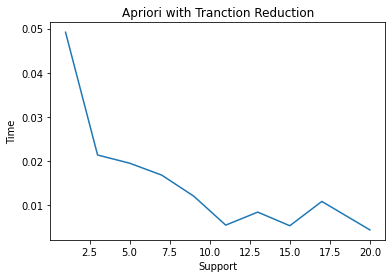

In [502]:
plt.xlabel("Support")
plt.ylabel("Time")
plt.title("Apriori with Tranction Reduction")
plt.plot( tranc_reduc_support, tranction_reduc_times)

In [510]:
tranc_reduction.frequent_item_set_gen(2)

({1: array([['I1'],
         ['I2'],
         ['I3'],
         ['I4'],
         ['I5']], dtype='<U2'),
  2: [['I1', 'I2'],
   ['I1', 'I3'],
   ['I1', 'I4'],
   ['I1', 'I5'],
   ['I2', 'I3'],
   ['I2', 'I4'],
   ['I2', 'I5'],
   ['I3', 'I4'],
   ['I3', 'I5'],
   ['I4', 'I5']],
  3: [['I1', 'I2', 'I3'],
   ['I1', 'I2', 'I5'],
   ['I1', 'I3', 'I5'],
   ['I2', 'I3', 'I4'],
   ['I2', 'I3', 'I5'],
   ['I2', 'I4', 'I5']],
  4: [['I1', 'I2', 'I3', 'I5']]},
 {1: [4, 5, 2, 2, 2], 2: [4, 2, 2, 2, 2, 2], 3: [2, 2], 4: []},
 {1: [],
  2: [['I1', 'I4'], ['I3', 'I4'], ['I3', 'I5'], ['I4', 'I5']],
  3: [],
  4: [['I1', 'I2', 'I3', 'I5']]})

Text(0.5, 1.0, 'Tranction Reduction')

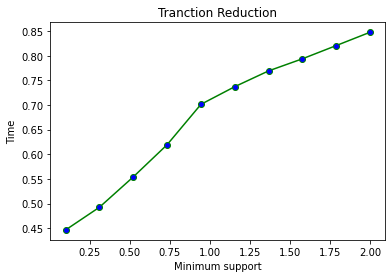

In [503]:
result_supports = []
result_times = []
for i in normal_support:
    stat_time = timeit.default_timer()
    tranc_reduction.frequent_item_set_gen(i)
    stop = timeit.default_timer()
    result_supports.append(i)
    result_times.append(stop - start_time)

# plotting the points
plt.plot(result_supports, result_times, color='green',
         marker='o', markerfacecolor='blue', markersize=6)


# naming the x axis
plt.xlabel('Minimum support')
# naming the y axis
plt.ylabel('Time')

# giving a title to my graph
plt.title('Tranction Reduction')

# function to show the plot
# plt.show()


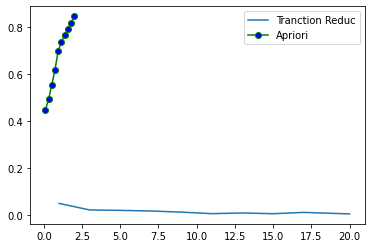

In [504]:
plt.plot( tranc_reduc_support, tranction_reduc_times, label='Tranction Reduc')
plt.plot(result_supports, result_times, color='green',
         marker='o', markerfacecolor='blue', markersize=6, label='Apriori')
plt.legend(loc='best')

In [505]:
support = np.array([4, 2, 1, 2, 2, 2, 2, 0, 1, 0])
combines = np.array([
    [0, 1],
    [0, 2],
    [0, 3],
    [0, 4],
    [1, 2],
    [1, 3],
    [1, 4],
    [2, 3],
    [2, 4],
    [3, 4], ])


In [506]:
# in frequent itemset 
combines[support < 2]

array([[0, 3],
       [2, 3],
       [2, 4],
       [3, 4]])

In [507]:
k_3_itmeset = np.array(
    [
        [0, 1, 2],
        [0, 1, 3],
        [0, 1, 4],
        [0, 2, 3],
        [0, 2, 4],
        [1, 2, 3],
        [1, 2, 4],
        [1, 3, 4],
    ]
)


In [508]:
itemset_reduct.values[k_3_itmeset]

array([], shape=(8, 3, 0), dtype=float64)

#### Calculating Support using Matrix 

In [509]:
a = np.array(
    [[1, 0],
     [1, 1],
     [0, 1],
     [1, 0],
     [1, 0],
     [1, 1],
     [1, 1]]
)
rc_values = np.array([1, 2, 2, 1, 1, 1, 1])
result = 0
for i in range(len(a)):
    temp = 0
    for k in range(len(a[i])):
        print(f"{a[i][k]}, { rc_values[i]} = {a[i][k] & rc_values[i]}")
        temp = temp + (a[i][k] & rc_values[i])

        print()
    result = result + temp
result


1, 1 = 1

0, 1 = 0

1, 2 = 0

1, 2 = 0

0, 2 = 0

1, 2 = 0

1, 1 = 1

0, 1 = 0

1, 1 = 1

0, 1 = 0

1, 1 = 1

1, 1 = 1

1, 1 = 1

1, 1 = 1



7